In [1]:
import glob
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.display import clear_output
from pandas.core.common import flatten


import keras
import tensorflow
from pickle import dump
from pickle import load
import kerastuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [2]:
alarm = '1037_L'

In [3]:
def create_df(alarm_name):
    """ Returns a dataset of all valve values and specific alarm column."""
    
    dfs = {file.split("_")[-4]: pd.read_pickle(file) for file in \
           glob.glob("S:\SRH\BDBA_Sem_2\Case_study_1\data\*.pkl")}
    
    dfs_sorted = dict(sorted(dfs.items()))
    df_single = pd.concat(dfs_sorted, axis=0)
    
    alarms = ['1031_H', '1031_L', '1034_H', '1034_L', '1037_H', '1037_L']
    alarms.remove(alarm_name)
    
    df_alarm = df_single.drop(alarms, axis=1)
    df_alarm.fillna(0, inplace=True)
    
    return df_alarm
    

In [4]:
df_alarm = create_df(alarm)

In [5]:
def input_sequence(data, past_seq_len, future_window):
    """ Creates a small input sequence of a given seq length and 
        returns two numpy arrays as input and output sequence
        
        Args:
        data: input dataframe
        past_seq_len: integer number
        future_window: integer number

        """
    target_df = data.iloc[:,-1]
    input_x = []
    output_y = []
    for i in range(len(data) - past_seq_len -1):
        ins = data.iloc[i:(i+past_seq_len), 0:data.shape[1]-1]
        ots = np.where((target_df.iloc[(i+past_seq_len):(i+past_seq_len+future_window)]>0).any(), 1, 0)
        input_x.append(ins)
        output_y.append(ots)
    in_array = np.array(input_x).astype(np.float32)
    out_array = np.array(output_y).astype(np.float32)
    
    return in_array, out_array.reshape(-1,1)

In [6]:
def preprocessed_df(df, val_pct):
    """ Creates train, validation and test set after applying normalisation of all feature cols
    Args:
    df: dataframe object
    val_pct: percentage size of validation plus test size (float)
    """
    
    val_data_size = round(df.shape[0] * val_pct)
    test_data_size = round(val_data_size * 0.1)
    
    train_data = df[:-val_data_size]
    val_data = df[-val_data_size:-test_data_size]
    test_data = df[-test_data_size:]
    
    # Scaling the data
    scalar = MinMaxScaler()
    scalar.fit(train_data.iloc[:,:-1])
    # save the scaler
    dump(scalar, open('model_objects\scaler_cls_'+alarm+'.pkl', 'wb'))
    
    train_scaled = scalar.transform(train_data.iloc[:,:-1]) 
    val_scaled = scalar.transform(val_data.iloc[:,:-1])
    test_scaled = scalar.transform(test_data.iloc[:,:-1])
    
    df_train = pd.DataFrame(train_scaled)
    df_train['alarm'] = train_data.iloc[:,-1].values
    df_val = pd.DataFrame(val_scaled)
    df_val['alarm'] = val_data.iloc[:,-1].values
    df_test = pd.DataFrame(test_scaled)
    df_test['alarm'] = test_data.iloc[:,-1].values
    
    return df_train, df_val, df_test

In [7]:
df_train, df_val, df_test = preprocessed_df(df_alarm, 0.3)

In [8]:
# specify the window size
n_steps = 15
future_window = 10
# split into samples
X_train, y_train = input_sequence(df_train, n_steps, future_window)
X_val, y_val = input_sequence(df_val, n_steps, future_window)
X_test, y_test = input_sequence(df_test, n_steps, future_window)

In [9]:
print(f"X_train.shape: {X_train.shape},y_train.shape: {y_train.shape}\n"
      f"X_val.shape: {X_val.shape}, y_val.shape: {y_val.shape}\n"
      f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (16673, 15, 6),y_train.shape: (16673, 1)
X_val.shape: (6422, 15, 6), y_val.shape: (6422, 1)
X_test.shape: (699, 15, 6), y_test.shape: (699, 1)


In [10]:
#Build Model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(100, kernel_initializer='he_normal',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))


# compile the model
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=8)

# Visualise model
logdir = "logs/ts_classification_"+alarm+"/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logdir)

# Create a callback that saves the model's weights
checkpoint_filepath = './tmp'+alarm+'/checkpoint'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# fit the model
model_history = model.fit(X_train, y_train, epochs=250, 
                          batch_size=32, verbose=2, 
                          validation_data=(X_val, y_val), 
                          callbacks=[es, tensorboard, model_checkpoint])

Epoch 1/250
522/522 - 15s - loss: 0.1282 - accuracy: 0.9682 - val_loss: 0.1497 - val_accuracy: 0.9564
Epoch 2/250
522/522 - 9s - loss: 0.0891 - accuracy: 0.9779 - val_loss: 0.1346 - val_accuracy: 0.9564
Epoch 3/250
522/522 - 10s - loss: 0.0786 - accuracy: 0.9778 - val_loss: 0.1274 - val_accuracy: 0.9564
Epoch 4/250
522/522 - 10s - loss: 0.0795 - accuracy: 0.9778 - val_loss: 0.1126 - val_accuracy: 0.9564
Epoch 5/250
522/522 - 10s - loss: 0.0737 - accuracy: 0.9778 - val_loss: 0.1098 - val_accuracy: 0.9564
Epoch 6/250
522/522 - 10s - loss: 0.0698 - accuracy: 0.9778 - val_loss: 0.1070 - val_accuracy: 0.9564
Epoch 7/250
522/522 - 10s - loss: 0.0633 - accuracy: 0.9778 - val_loss: 0.1073 - val_accuracy: 0.9564
Epoch 8/250
522/522 - 10s - loss: 0.0656 - accuracy: 0.9778 - val_loss: 0.1044 - val_accuracy: 0.9564
Epoch 9/250
522/522 - 10s - loss: 0.0653 - accuracy: 0.9778 - val_loss: 0.1133 - val_accuracy: 0.9564
Epoch 10/250
522/522 - 10s - loss: 0.0596 - accuracy: 0.9778 - val_loss: 0.1072 - v

In [11]:
# Loads the weights
model.load_weights('./tmp'+alarm+'/checkpoint')

# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy: {:5.2f}%".format(100 * acc))

22/22 - 0s - loss: 0.2131 - accuracy: 0.9428
Test accuracy: 94.28%


In [12]:
# load the scaler
scalar = load(open(f'S:\SRH\caseStudy1\Codes\codes_classification\model_objects\scaler_cls_{alarm}.pkl', 'rb'))

In [30]:
yhat = model.predict(X_test).argmax(axis=-1)

In [32]:
# yhat = model.predict_classes(X_test)
# yhat = scalar.inverse_transform(yhat)

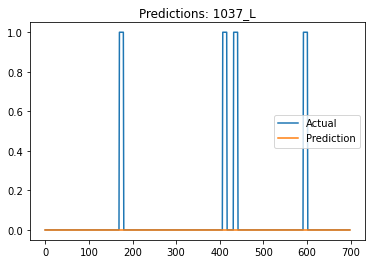

In [31]:
plt.plot(y_test, label="Actual")
plt.plot(yhat, label="Prediction")
plt.legend()
plt.title(f'Predictions: {alarm}')
plt.savefig(f'{alarm}_classification_{future_window}.png')

In [16]:
def model_builder(hp):
    """ Return model objective using keras tuner for hyperparameters"""
    
    model = Sequential()
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(LSTM(hp_units, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(LSTM(hp_units, kernel_initializer='he_normal', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    # Tune the learning rate for the optimizer 
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate)
    # compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=8)

# Visualise model
logdir = "logs/ts_classification_tuned"+alarm+"/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logdir)

# Create a callback that saves the model's weights
checkpoint_filepath = './tmp_tuned_'+alarm+'/checkpoint'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#define a callback to clear the training outputs at the end of every training step
class ClearTrainingOutput(tensorflow.keras.callbacks.Callback):
      def on_train_end(*args, **kwargs):
            clear_output(wait = True)

In [18]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 30,
                     factor = 3,
                     directory = logdir,
                     project_name = 'ts_classification')

tuner.search(X_train, y_train, epochs=25, 
                          batch_size=32, verbose=2, 
                          validation_data=(X_val, y_val), 
                          callbacks=[es, tensorboard, model_checkpoint, ClearTrainingOutput()])

Trial 64 Complete [00h 59m 46s]
val_accuracy: 0.9405169486999512

Best val_accuracy So Far: 0.956244170665741
Total elapsed time: 05h 52m 56s
INFO:tensorflow:Oracle triggered exit
